# Registration

Registration is the process of finding a spatial transformation that aligns two pointclouds. Here we consider only rigid registrations (i.e., composed of a rotation and a translation).

In [1]:
# Necessary imports
import sys
import time
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

sys.path.append("./utils")
from manip_utils import rotation_zyx

## Registration between corresponding sets

We assume the correspondance of points between pointclouds $P$ and $Q$.

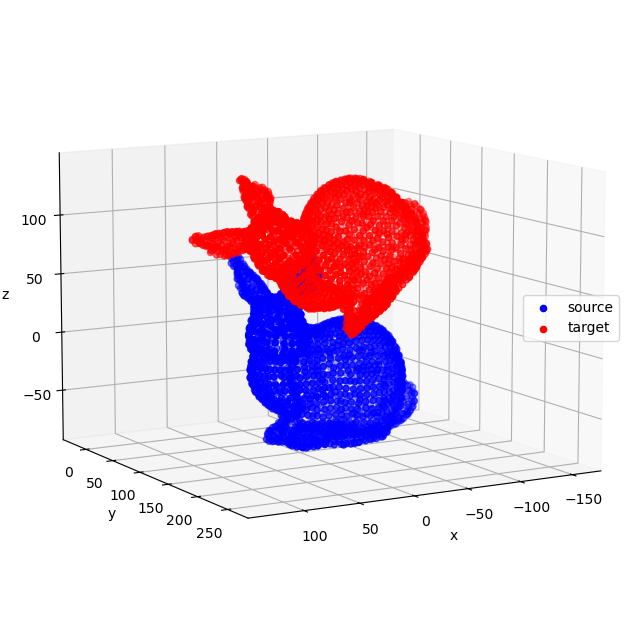

In [2]:
data = np.loadtxt("./data/standford_bunny_custom.xyz")
points = data[:, :3]
normals = data[:, 7:]

R_true = rotation_zyx(theta_x=np.pi/5, theta_y=np.pi/6, theta_z=np.pi/7)
T_true = np.array([10., 20., 30.])

points_transformed = (R_true @ points.T).T + T_true
normals_transformed = (R_true @ normals.T).T          

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', label="source")
ax.scatter(points_transformed[:, 0], points_transformed[:, 1], points_transformed[:, 2],
           c='red', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


### Point-to-point

\begin{equation*}
(R_{opt}, t_{opt}) = \arg\min_{R, t} \sum^{n-1}_{0} \omega_{i} || R \cdot p_{i} + t - q_{i} ||^{2}
\end{equation*}

See Sorkine-Hornung, O., & Rabinovich, M. (2017). Least-squares rigid motion using svd. *Computing*, 1(1), 1-5.

In [3]:
def point_to_point_minimization(p, q, w):
    """Compute the best fitting rigit transformation (p to q) that minimizes
    the sum of squared distances between two sets of corresponding points"""

    # Compute the weighted centroids of both point sets
    p_bar = (w @ p)/w.sum()
    q_bar = (w @ q)/w.sum()
    # Compute the centered matrices
    x = p - p_bar
    y = q - q_bar
    # Cross covariance matrix
    S = x.T @ (w[:, None] * y)
    # Singular Value Decomposition
    U, _, V = np.linalg.svd(S)
    # Optimal rotation
    R = (U @ V).T
    # Symmetry test
    if np.linalg.det(R) < 0.0:
        V[2, :] *= -1
        R = (U @ V).T
    # Optimal translation
    T = q_bar - (R @ p_bar)

    return R, T

def point_to_point_error(p, q, w):
    """Compute the Root Mean Squared Error (RMS) for point-to-point distance"""

    se = ((w[:, None] * (p - q))**2).sum(axis=1)
    mse = se.mean()
    
    return np.sqrt(mse)
    

#
weights = np.ones(len(points))
initial_error = point_to_point_error(points, points_transformed, weights)
print("Initial error of", initial_error)

#
R_point, T_point = point_to_point_minimization(points, points_transformed, weights)
points_transformed_calc = (R_point @ points.T).T + T_point
final_error = point_to_point_error(points_transformed_calc, points_transformed, weights)
print("Final error of", final_error)

# Check
print("Check if rotations R_true and R_point are the same:", np.allclose(R_true, R_point))
print("Check if translations T_true and T_point are the same:", np.allclose(T_true, T_point))


Initial error of 109.4062239747127
Final error of 9.762090481064563e-14
Check if rotations R_true and R_point are the same: True
Check if translations T_true and T_point are the same: True


### Point to plane

\begin{equation*}
(R_{opt}, t_{opt}) = \arg\min_{R, t} \sum^{n-1}_{0} \omega_{i} [ (R \cdot p_{i} + t - q_{i}) \cdot n_{q, i} ]^{2}
\end{equation*}

See Low, K. L. (2004). Linear least-squares optimization for point-to-plane icp surface registration. *Chapel Hill, University of North Carolina*, 4(10), 1-3.

In [4]:
def point_to_plane_minimization(p, q, n_q, w):
    """Compute the best fitting rigit transformation (p to q) that minimizes
    the sum of squared distances between a data set of points and the tangent plane
    at its corresponding set of points in ref (linearized form)"""

    # Apply weight
    n_w = w[:, None] * n_q
    # Solving A.X = b (linearized form of the equation)
    A = np.hstack((np.cross(p, n_w), n_w))
    b = np.sum(n_w*(q-p), axis=1)
    x = np.linalg.pinv(A) @ b
    # Unpack result
    theta_x, theta_y, theta_z, t_x, t_y, t_z = x
    R = rotation_zyx(theta_x, theta_y, theta_z)
    T = np.array([t_x, t_y, t_z])

    return R, T

def point_to_plane_error(p, q, n_q, w):
    """Compute the Root Mean Squared Error (RMS) for point-to-plane distance"""

    se = (w[:, None] * (n_q * (p - q))**2).sum(axis=1)

    return se.mean()

#
weights = np.ones(len(points))
initial_error = point_to_plane_error(points, points_transformed, normals_transformed, weights)
print("Initial error of", initial_error)

#
R_plane, T_plane = point_to_plane_minimization(points, points_transformed, normals_transformed, weights)
points_transformed_calc = (R_point @ points.T).T + T_point
final_error = point_to_plane_error(points_transformed_calc, points_transformed, normals_transformed, weights)
print("Final error of", final_error)

# Check
print("Check if rotations R_true and R_plane are the same:", np.allclose(R_true, R_plane))
print("Check if translations T_true and T_plane are the same:", np.allclose(T_true, T_plane))



Initial error of 4224.690696982299
Final error of 3.2562142656600264e-27
Check if rotations R_true and R_plane are the same: False
Check if translations T_true and T_plane are the same: False


## Registration between non-corresponding sets

We do not assume the correspondance of points between pointclouds $P$ and $Q$.

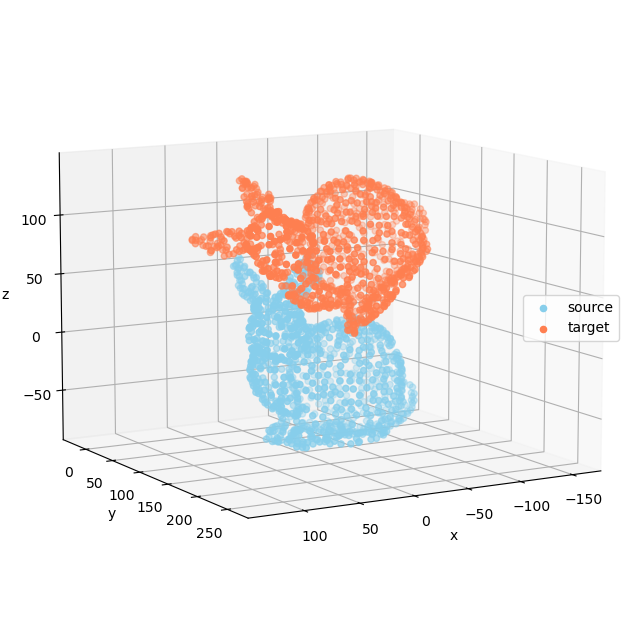

In [5]:
# Even indices
points_sub = points[::2]
normals_sub = normals[::2]

# Odd indices
points_transformed_sub = points_transformed[1::2]
normals_transformed_sub = normals_transformed[1::2]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2],
           c='skyblue', label="source")
ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()

### Fine Matching and the Iterative Closest Point (ICP) Algorithm

ICP is one on the most popular algorithm to perform registration. Find the most accurate transformation as possible.

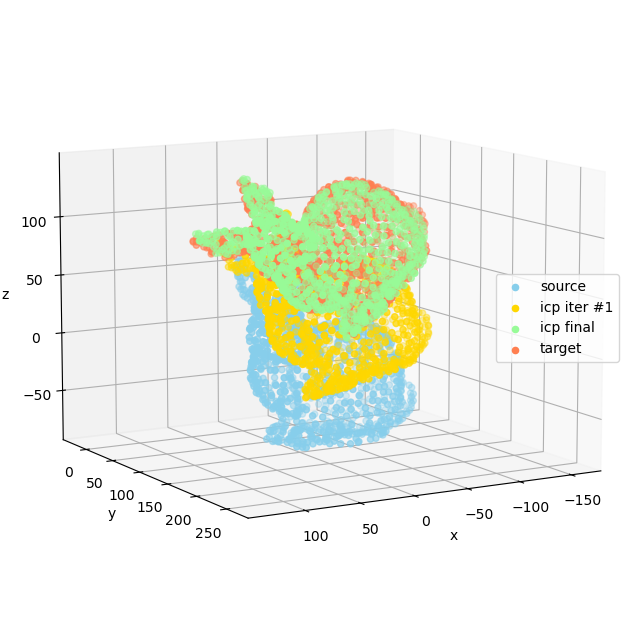

In [6]:
def register_simple_icp(source, target, max_iter):

    # Initialization
    kdtree = KDTree(target)
    Rt = [np.eye(3)]
    Tt = [np.zeros(3)]
    err = []

    for i in range(max_iter):

        _, match = kdtree.query(source)

        target_match = target[match]

        weights = np.ones(len(source))
        R, T = point_to_point_minimization(source, target_match, weights)

        source = (R @ source.T).T + T

        rms = point_to_point_error(source, target_match, weights)

        # Store the result
        Rt.append(R @ Rt[i])
        Tt.append(R @ Tt[i] + T)
        err.append(rms)

    return Rt, Tt, err


Rt, Tt, err = register_simple_icp(points_sub, points_transformed_sub, 20)

points_sub_icp_1 = (Rt[1] @ points_sub.T).T + Tt[1]

points_sub_icp = (Rt[-1] @ points_sub.T).T + Tt[-1]


fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2],
           c='skyblue', label="source")
ax.scatter(points_sub_icp_1[:, 0], points_sub_icp_1[:, 1], points_sub_icp_1[:, 2],
           c='gold', label="icp iter #1")
ax.scatter(points_sub_icp[:, 0], points_sub_icp[:, 1], points_sub_icp[:, 2],
           c='palegreen', label="icp final")
ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()


Convergence analysis.

Check if rotations R_true and R_plane are the same: False
Check if translations T_true and T_plane are the same: False


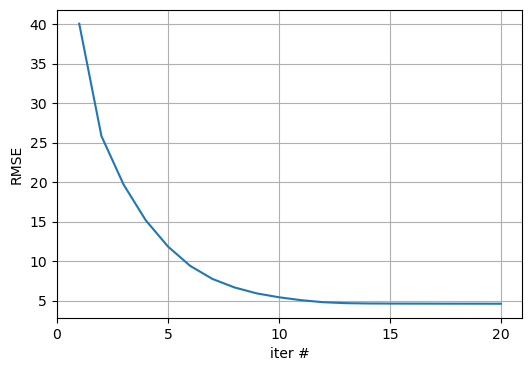

In [7]:
print("Check if rotations R_true and R_plane are the same:", np.allclose(R_true, Rt[-1]))
print("Check if translations T_true and T_plane are the same:", np.allclose(T_true, Tt[-1]))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.plot(range(1, len(err)+1), err)
ax.set(xlabel='iter #', ylabel='RMSE',
       xticks=range(0, len(err)+1, 5))
ax.grid()
plt.show()

More complicated one.

In [8]:
def register_icp(source, target, max_iter):

    return


### Coarse Matching and Principal Axis Alignment

Coarse registration techniques return a rough initial alignment of the source pointcloud, without any initial alignment or hypothesis.

Although it is not robust to noise and sensible to errors and occlusions, PCA is one of the fastest methods

In [9]:
def register_pca(source, target):

    # Centered matrices
    M = source - source.mean(axis=0)
    N = target - target.mean(axis=0)

    # Singular Value Decomposition
    U_M, s_M, Vt_M = np.linalg.svd(M)
    U_N, s_N, Vt_N = np.linalg.svd(N)

    # Rotation matrix
    R = Vt_N.T @ Vt_M

    # Choice of the good symmetries
    candidates = []
    if np.linalg.det(R) < 0.0:
        # If sign < 0 then the following symmetries are tested
        # x, y, and z
        for i in range(3):
            Vt_M1 = np.array(Vt_M)
            Vt_M1[i, :] *= -1
            candidates.append(Vt_N.T @ Vt_M1)
        # and xyz
        candidates.append(-R)
    else:
        # If sign > 0 then the following symmetries are tested
        # xy, xz, and yz
        for i in range(3):
            Vt_M1 = np.array(Vt_M)
            Vt_M1[i, :] *= -1
            Vt_M1[i-1, :] *= -1
            candidates.append(Vt_N.T @ Vt_M1)
        # and 0
        candidates.append(R)

    # The best candidate is the one that obtains the best bounding box matches
    N_min = N.min(axis=0)
    N_max = N.max(axis=0)

    mismatch = np.inf

    for R in candidates:
        RM = R @ M.T
        RM_min = RM.min(axis=1)
        RM_max = RM.max(axis=1)
        d = np.linalg.norm(RM_min - N_min) + np.linalg.norm(RM_max - N_max)
        if d < mismatch:
            R_opt = R
            mismatch = d

    # Translation vector
    T_opt = target.mean(axis=0) - R_opt @ source.mean(axis=0)

    return R_opt, T_opt




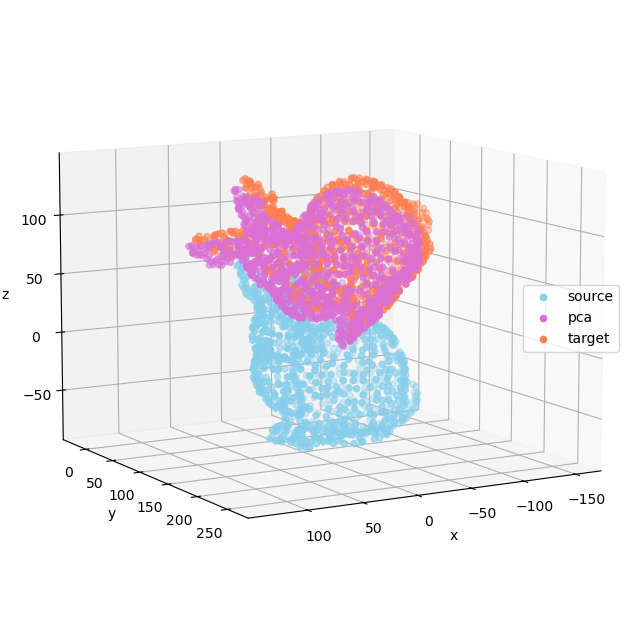

In [10]:
R_pca, T_pca = register_pca(points_sub, points_transformed_sub)

points_sub_pca = (R_pca @ points_sub.T).T + T_pca[1]

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points_sub[:, 0], points_sub[:, 1], points_sub[:, 2],
           c='skyblue', label="source")

ax.scatter(points_sub_pca[:, 0], points_sub_pca[:, 1], points_sub_pca[:, 2],
           c='orchid', label="pca")


ax.scatter(points_transformed_sub[:, 0], points_transformed_sub[:, 1], points_transformed_sub[:, 2],
           c='coral', label="target")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(loc="right")
ax.view_init(10, 60)
plt.axis("equal")
plt.show()
